<a href="https://colab.research.google.com/github/argareeva/DataAnalyticsProject/blob/main/%D0%9C%D1%83%D1%80%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.4 MB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Book3.csv', delimiter=';')

data_numeric = data.drop(columns=['#'])

print(data_numeric.info())
print(data_numeric.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Прекурсор       10 non-null     int64  
 1   Растворитель    10 non-null     int64  
 2   t, C            10 non-null     int64  
 3   t, ч            10 non-null     int64  
 4   pH              10 non-null     float64
 5   HNO3            10 non-null     int64  
 6   CH3COOH         10 non-null     int64  
 7   HCl             10 non-null     int64  
 8   H2SO4           10 non-null     int64  
 9   t1, C           1 non-null      float64
 10  H1, Дж/г        1 non-null      float64
 11  t2, C           1 non-null      float64
 12  H2, Дж/г        1 non-null      float64
 13  Фазовый состав  10 non-null     int64  
 14  a(842)          10 non-null     float64
 15  D(842), нм      10 non-null     float64
 16  SBET, м2/г      7 non-null      float64
 17  Vпор, см3/г     7 non-null      float6

1 вариант - делаем xgboost на 3 строках, оставляем остальные признаки

In [32]:
df_cleaned = data_numeric.dropna(subset=['d1, нм', 'd2, нм ', 'w1, %', 'w2, %'])


df_cleaned.head()

,Прекурсор,Растворитель,"t, C","t, ч",pH,HNO3,CH3COOH,HCl,H2SO4,"t1, C",...,A1(C),A2(C),A1(O),A2(O),A1(Fe),A2(Fe),"d1, нм","d2, нм","w1, %","w2, %"
0,11,21,150,8,1.5,31,0,0,0,NaN,...,70.21,69.70,25.92,26.97,3.85,3.25,9.7,25.9,86.06,13.94
1,12,22,24,24,6.0,0,0,0,0,114.7,...,NaN,NaN,NaN,NaN,NaN,NaN,9.1,24.0,90.28,9.72
2,12,22,24,24,5.0,0,0,0,0,NaN,...,68.00,66.57,21.47,27.95,10.51,5.46,9.9,25.3,96.49,3.51


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

X = df_cleaned.drop(columns=['d1, нм', 'd2, нм ', 'w1, %', 'w2, %'])
y = df_cleaned[['d1, нм', 'd2, нм ', 'w1, %', 'w2, %']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}
grid_search = GridSearchCV(xgboost_model, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Оптимальные параметры:", grid_search.best_params_)

xgboost_y_pred = grid_search.best_estimator_.predict(X_test)

xgboost_mae = mean_absolute_error(y_test, xgboost_y_pred)
xgboost_mse = mean_squared_error(y_test, xgboost_y_pred)

print(f'MAE (XGBoost): {xgboost_mae:.4}')
print(f'MSE (XGBoost): {xgboost_mse:.4}')

Оптимальные параметры: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
MAE (XGBoost): 5.292
MSE (XGBoost): 51.89


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

xgboost_model = XGBRegressor(learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, objective='reg:squarederror', random_state=42)
xgboost_model.fit(X_train, y_train)

xgboost_y_pred = xgboost_model.predict(X_test)
xgboost_mae = mean_absolute_error(y_test, xgboost_y_pred)
xgboost_mse = mean_squared_error(y_test, xgboost_y_pred)

print(f'MAE (Tuned XGBoost): {xgboost_mae:.4}')
print(f'MSE (Tuned XGBoost): {xgboost_mse:.4}')

MAE (Tuned XGBoost): 5.292
MSE (Tuned XGBoost): 51.89


In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=2, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Среднее значение RMSE на кросс-валидации: {cv_rmse_scores.mean():.4}')

Среднее значение RMSE на кросс-валидации: 4.445


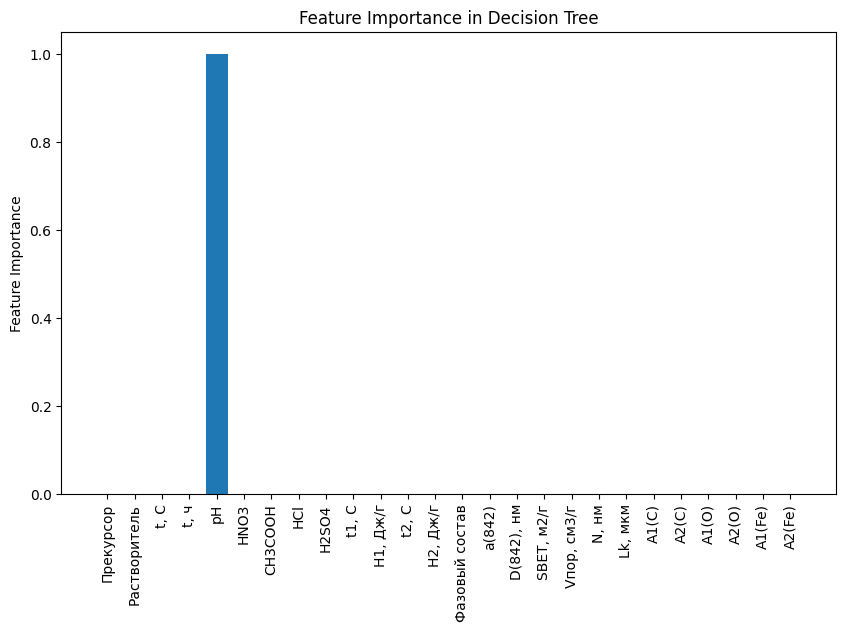

In [17]:
import matplotlib.pyplot as plt

feature_importance = xgboost_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.bar(features, feature_importance)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Decision Tree')

plt.show()

2 вариант - удаляем все признаки с nan


---

1. decision tree на трех строках
2. линейная регрессия на трех строках

In [35]:
df_cleaned = data_numeric.dropna(subset=['d1, нм', 'd2, нм ', 'w1, %', 'w2, %'])

df_cleaned = df_cleaned.drop(columns=['t1, C', 'H1, Дж/г', 't2, C', 'H2, Дж/г', 'N, нм', 'Lk, мкм', 'A1(C)', 'A2(C)', 'A1(O)', 'A2(O)', 'A1(Fe)', 'A2(Fe)'])

df_cleaned.head(7)

,Прекурсор,Растворитель,"t, C","t, ч",pH,HNO3,CH3COOH,HCl,H2SO4,Фазовый состав,a(842),"D(842), нм","SBET, м2/г","Vпор, см3/г","d1, нм","d2, нм","w1, %","w2, %"
0,11,21,150,8,1.5,31,0,0,0,41,72.76,33.4,1261.0,0.708,9.7,25.9,86.06,13.94
1,12,22,24,24,6.0,0,0,0,0,41,73.09,37.8,1827.4,1.001,9.1,24.0,90.28,9.72
2,12,22,24,24,5.0,0,0,0,0,41,72.48,21.3,6527.1,3.311,9.9,25.3,96.49,3.51


In [36]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor

X = df_cleaned.drop(columns=['d1, нм', 'd2, нм ', 'w1, %', 'w2, %'])
y = df_cleaned[['d1, нм', 'd2, нм ', 'w1, %', 'w2, %']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt_model, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)


print("Оптимальные параметры:", grid_search_dt.best_params_)

y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)

print(f'MAE (Decision Tree): {mae_dt:.4}')
print(f'MSE (Decision Tree): {mse_dt:.4}')

Оптимальные параметры: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
MAE (Decision Tree): 5.415
MSE (Decision Tree): 54.49


In [37]:
dt_model_tuned = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=2, random_state=42)
dt_model_tuned.fit(X_train, y_train)

y_pred_dt_tuned = dt_model_tuned.predict(X_test)

mae_dt_tuned = mean_absolute_error(y_test, y_pred_dt_tuned)
mse_dt_tuned = mean_squared_error(y_test, y_pred_dt_tuned)

print(f'MAE (Tuned Decision Tree): {mae_dt_tuned:.4}')
print(f'MSE (Tuned Decision Tree): {mse_dt_tuned:.4}')

MAE (Tuned Decision Tree): 2.735
MSE (Tuned Decision Tree): 9.897


In [27]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(dt_model_tuned, X_train, y_train, cv=2, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Среднее значение RMSE на кросс-валидации: {cv_rmse_scores.mean():.4}')

Среднее значение RMSE на кросс-валидации: 4.457


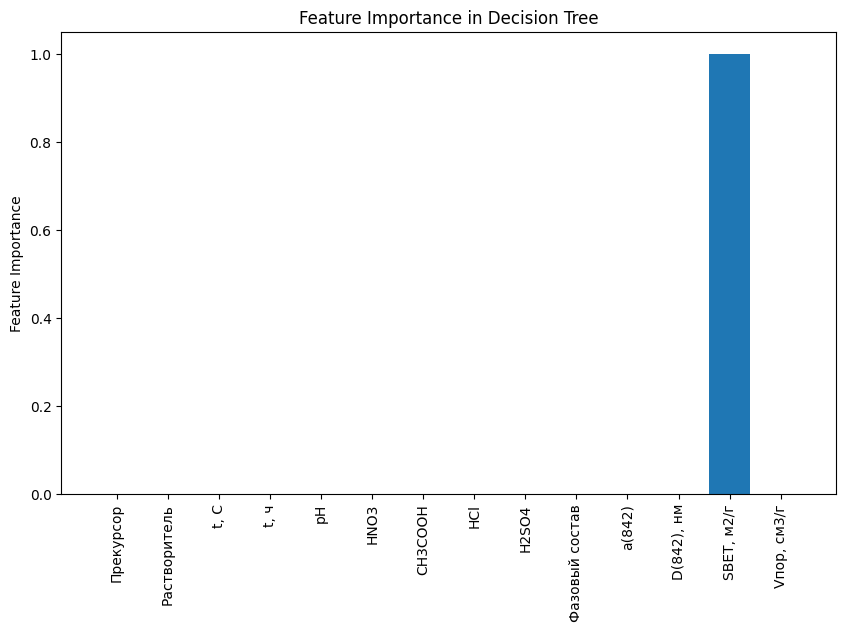

In [28]:
import matplotlib.pyplot as plt

feature_importance = dt_model_tuned.feature_importances_
features = X.columns


plt.figure(figsize=(10, 6))
plt.bar(features, feature_importance)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Decision Tree')

plt.show()

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_cleaned.drop(columns=['d1, нм', 'd2, нм ', 'w1, %', 'w2, %'])
y = df_cleaned[['d1, нм', 'd2, нм ', 'w1, %', 'w2, %']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'MAE: {mae:.4}')
print(f'MSE: {mse:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight_d1': lr_model.coef_[0],
                                'Weight_d2': lr_model.coef_[1], 'Weight_w1': lr_model.coef_[2],
                                'Weight_w2': lr_model.coef_[3]})
print(feature_weights)

MAE: 2.424
MSE: 7.205
           Feature     Weight_d1     Weight_d2     Weight_w1     Weight_w2
0        Прекурсор  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1     Растворитель  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
2             t, C  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
3             t, ч  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
4               pH -3.621965e-08 -5.885693e-08 -2.811550e-07  2.811550e-07
5             HNO3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
6          CH3COOH  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
7              HCl  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
8            H2SO4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
9   Фазовый состав  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
10          a(842) -2.209399e-08 -3.590273e-08 -1.715046e-07  1.715046e-07
11      D(842), нм -5.976242e-07 -9.711393e-07 -4.639058e-06  4.639058e-06
12 

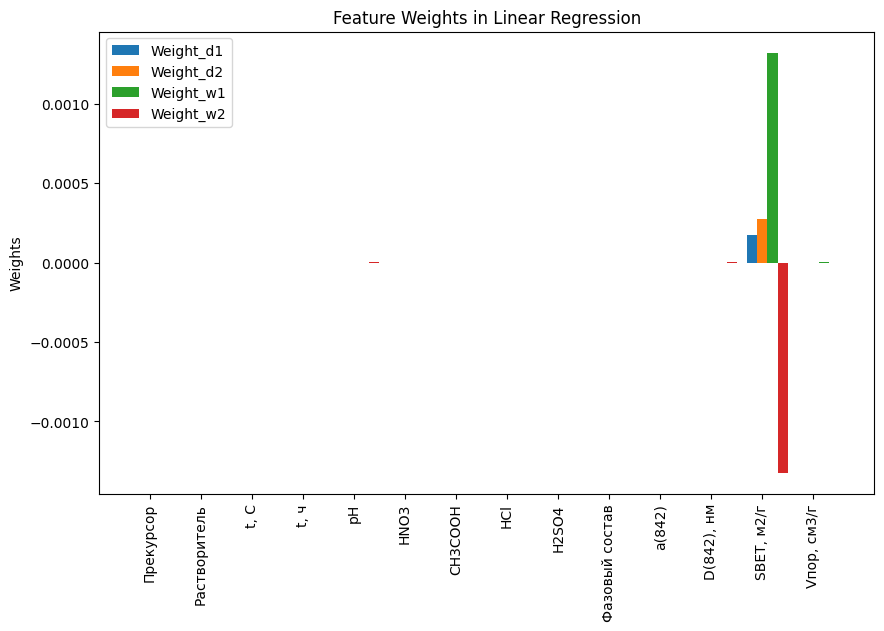

In [31]:
import matplotlib.pyplot as plt
import numpy as np

weights_d1 = lr_model.coef_[0]
weights_d2 = lr_model.coef_[1]
weights_w1 = lr_model.coef_[2]
weights_w2 = lr_model.coef_[3]

features = X.columns

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2

r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

ax.bar(r1, weights_d1, width=bar_width, label='Weight_d1')
ax.bar(r2, weights_d2, width=bar_width, label='Weight_d2')
ax.bar(r3, weights_w1, width=bar_width, label='Weight_w1')
ax.bar(r4, weights_w2, width=bar_width, label='Weight_w2')

ax.set_xticks([r + bar_width for r in range(len(features))])
ax.set_xticklabels(features, rotation=90)
ax.set_ylabel('Weights')
ax.set_title('Feature Weights in Linear Regression')
ax.legend()

plt.show()